# Compare Baseline vs Quantum Models

This notebook compares the performance of baseline and quantum-enhanced GAT models.

## Overview
1. Load saved metrics
2. Compare test set performance
3. Visualize improvements
4. Generate ROC curves for both models

**Estimated time:** 2-5 minutes

In [ ]:
# Clear any cached src imports
import sys
if 'src' in sys.modules:
    del sys.modules['src']
for key in list(sys.modules.keys()):
    if key.startswith('src.'):
        del sys.modules[key]
print("✓ Cleared cached imports")

In [ ]:
# Cell 1: Import libraries and setup
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Always add project root to sys.path for src imports (Jupyter-safe)
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

from src.models import GAT
from src.config import MODEL_CONFIG, TRAINING_CONFIG, ARTIFACTS_DIR, FIGURES_DIR, ARTIFACT_FILES, FIGURE_FILES
from src.utils import get_device

device = get_device()
print(f"Using device: {device}")

Device: cpu
Using device: cpu


In [ ]:
# Cell 2: Load baseline and quantum metrics
baseline_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_metrics']
with open(baseline_path, 'r') as f:
    baseline_metrics = json.load(f)

quantum_path = ARTIFACTS_DIR / ARTIFACT_FILES['quantum_metrics']
with open(quantum_path, 'r') as f:
    quantum_metrics_raw = json.load(f)

# Handle different metric file formats
# If quantum metrics don't have nested structure, wrap them
if 'performance' not in quantum_metrics_raw:
    quantum_metrics = {
        'performance': {
            'test': quantum_metrics_raw
        }
    }
else:
    quantum_metrics = quantum_metrics_raw

print("✓ Metrics loaded successfully")
print(f"  Baseline test accuracy: {baseline_metrics['performance']['test']['accuracy']:.4f}")
print(f"  Quantum test accuracy: {quantum_metrics['performance']['test']['accuracy']:.4f}")

✓ Metrics loaded successfully
  Baseline test accuracy: 0.9648
  Quantum test accuracy: 0.7609


In [ ]:
# Cell 3: Compare baseline vs quantum performance
print("\n" + "="*60)
print("BASELINE vs QUANTUM GAT COMPARISON")
print("="*60)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for split in ['test']:
    print(f"\n{split.upper()} SET:")
    print(f"{'Metric':<15} {'Baseline':<12} {'Quantum':<12} {'Improvement':<12}")
    print("-" * 60)
    
    for metric in metrics_to_compare:
        baseline_val = baseline_metrics['performance'][split][metric]
        quantum_val = quantum_metrics['performance'][split][metric]
        improvement = quantum_val - baseline_val
        
        print(f"{metric:<15} {baseline_val:<12.4f} {quantum_val:<12.4f} {improvement:+.4f}")


BASELINE vs QUANTUM GAT COMPARISON

TEST SET:
Metric          Baseline     Quantum      Improvement 
------------------------------------------------------------
accuracy        0.9648       0.7609       -0.2039
precision       0.8787       0.1418       -0.7369
recall          0.7415       0.2871       -0.4543
f1              0.8043       0.1899       -0.6144
roc_auc         0.9727       0.5542       -0.4185


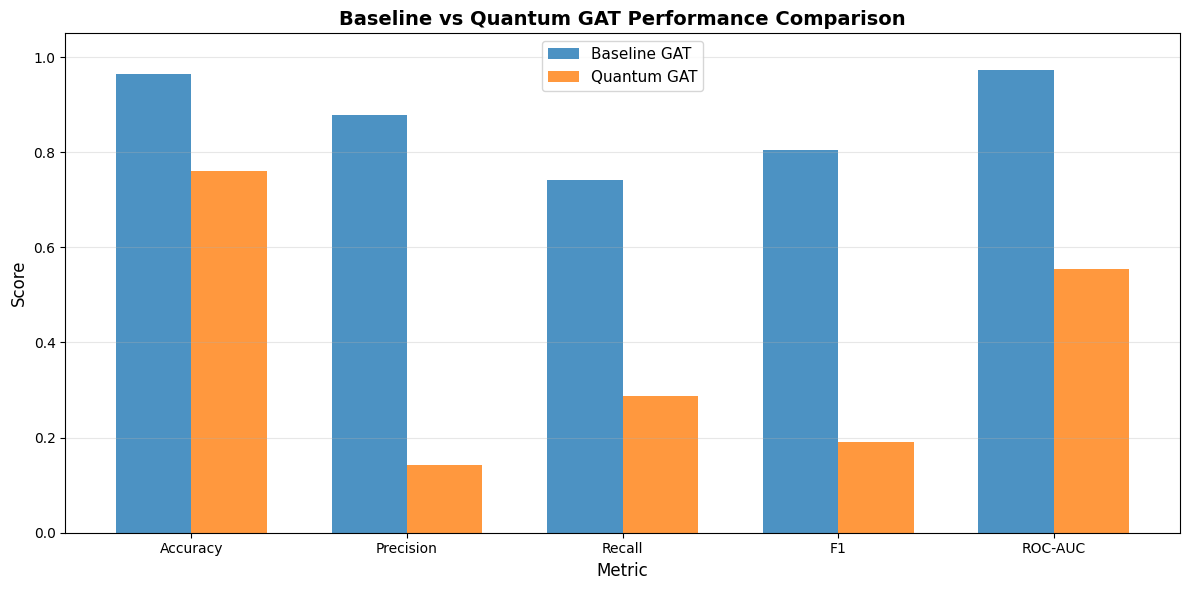

✓ Comparison chart saved to c:\Users\tusha\Documents\UT_Dallas\ACM_SP26\imple2\figures\baseline_vs_quantum_comparison.png


In [ ]:
# Cell 4: Visualize performance comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
baseline_vals = [baseline_metrics['performance']['test'][m] for m in metrics_to_compare]
quantum_vals = [quantum_metrics['performance']['test'][m] for m in metrics_to_compare]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline GAT', alpha=0.8, color='#1f77b4')
bars2 = ax.bar(x + width/2, quantum_vals, width, label='Quantum GAT', alpha=0.8, color='#ff7f0e')

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline vs Quantum GAT Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['comparison']
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Comparison chart saved to {save_path}")

In [ ]:
# Cell 5: Load quantum model and data
from sklearn.model_selection import train_test_split

graph_path = ARTIFACTS_DIR / ARTIFACT_FILES['quantum_graph']
data = torch.load(graph_path, map_location=device, weights_only=False)

# Create test mask if it doesn't exist
if not hasattr(data, 'test_mask'):
    print("Creating train/val/test splits...")
    labeled_indices = torch.where(data.labeled_mask)[0].cpu().numpy()
    labeled_y = data.y[data.labeled_mask].cpu().numpy()
    
    train_val_idx, test_idx = train_test_split(
        labeled_indices, test_size=0.2, 
        random_state=TRAINING_CONFIG['random_seed'],
        stratify=labeled_y
    )
    
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask[test_idx] = True
    data.test_mask = test_mask.to(device)
    print(f"  Test set size: {test_mask.sum()}")

model = GAT(
    in_channels=data.num_node_features,
    hidden_channels=MODEL_CONFIG['hidden_channels'],
    out_channels=MODEL_CONFIG['out_channels'],
    num_heads=MODEL_CONFIG['num_heads'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout']
).to(device)

model_path = ARTIFACTS_DIR / ARTIFACT_FILES['quantum_model']
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Handle different checkpoint formats
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)
    
model.eval()

print(f"✓ Quantum model loaded with {data.num_node_features} features")

Creating train/val/test splits...
  Test set size: 9313
✓ Quantum model loaded with 364 features


In [ ]:
# Cell 6: Generate predictions
@torch.no_grad()
def get_predictions():
    out = model(data.x, data.edge_index)
    probs = F.softmax(out, dim=1)
    preds = out.argmax(dim=1)
    return preds, probs

predictions, probabilities = get_predictions()
print(f"✓ Generated predictions for {data.num_nodes} nodes")

# Check for NaN/Inf values
if torch.isnan(probabilities).any():
    print(f"⚠️ Warning: {torch.isnan(probabilities).sum().item()} NaN values found in probabilities")
if torch.isinf(probabilities).any():
    print(f"⚠️ Warning: {torch.isinf(probabilities).sum().item()} Inf values found in probabilities")

✓ Generated predictions for 203769 nodes


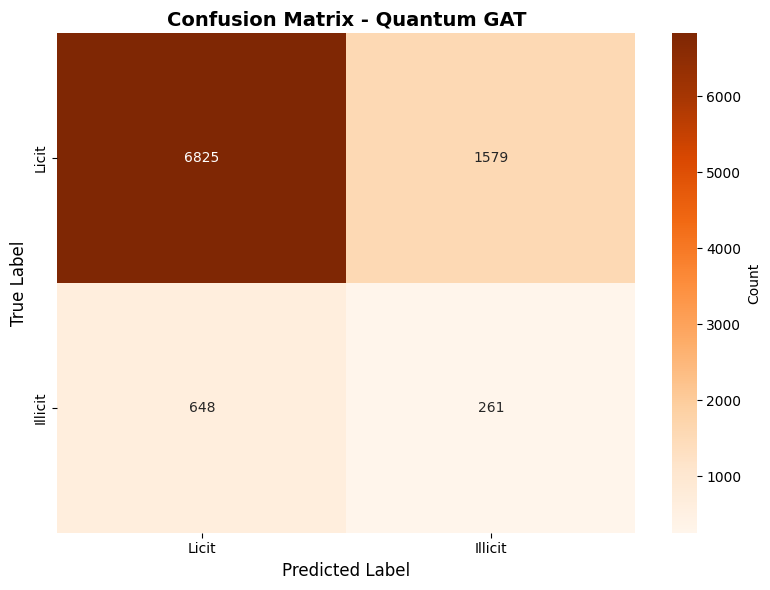

✓ Confusion matrix saved to c:\Users\tusha\Documents\UT_Dallas\ACM_SP26\imple2\figures\quantum_confusion_matrix.png


In [ ]:
# Cell 7: Generate confusion matrix for quantum model
from sklearn.metrics import confusion_matrix

y_test = data.y[data.test_mask].cpu().numpy()
y_pred = predictions[data.test_mask].cpu().numpy()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Licit', 'Illicit'],
            yticklabels=['Licit', 'Illicit'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Quantum GAT', fontsize=14, fontweight='bold')
plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['quantum_confusion']
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix saved to {save_path}")

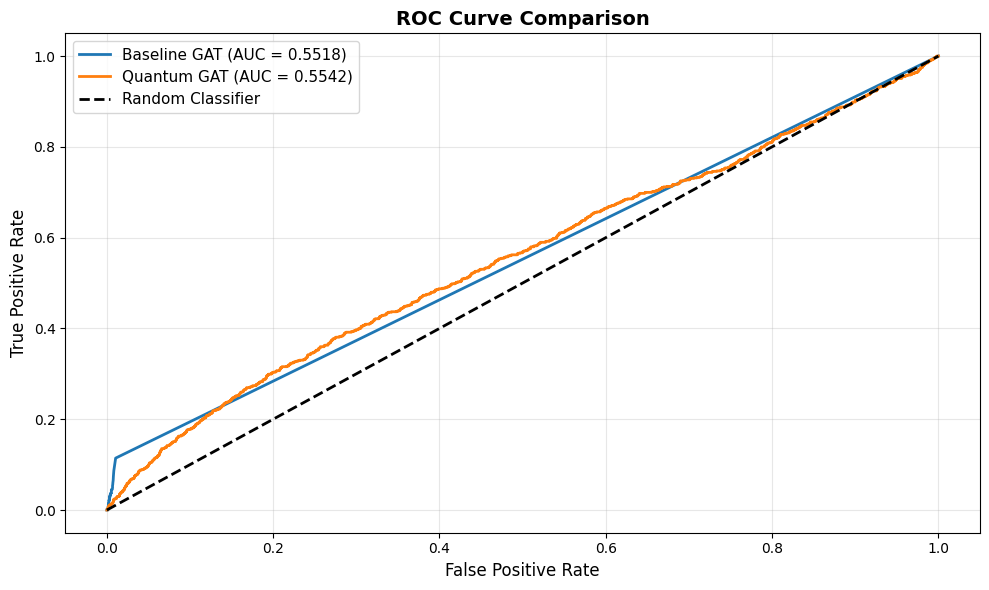


Baseline AUC: 0.5518
Quantum AUC:  0.5542
Improvement:  +0.0024
✓ ROC comparison saved to c:\Users\tusha\Documents\UT_Dallas\ACM_SP26\imple2\figures\roc_comparison.png


In [ ]:
# Cell 8: Compare ROC curves
from sklearn.metrics import roc_curve, auc

# Load baseline model
baseline_graph_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_graph']
data_baseline = torch.load(baseline_graph_path, map_location=device, weights_only=False)

# Create test mask for baseline if it doesn't exist
if not hasattr(data_baseline, 'test_mask'):
    labeled_indices = torch.where(data_baseline.labeled_mask)[0].cpu().numpy()
    labeled_y = data_baseline.y[data_baseline.labeled_mask].cpu().numpy()
    
    train_val_idx, test_idx = train_test_split(
        labeled_indices, test_size=0.2, 
        random_state=TRAINING_CONFIG['random_seed'],
        stratify=labeled_y
    )
    
    test_mask = torch.zeros(data_baseline.num_nodes, dtype=torch.bool)
    test_mask[test_idx] = True
    data_baseline.test_mask = test_mask.to(device)

model_baseline = GAT(
    in_channels=data_baseline.num_node_features,
    hidden_channels=MODEL_CONFIG['hidden_channels'],
    out_channels=MODEL_CONFIG['out_channels'],
    num_heads=MODEL_CONFIG['num_heads'],
    num_layers=MODEL_CONFIG['num_layers'],
    dropout=MODEL_CONFIG['dropout']
).to(device)

baseline_model_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_model']
checkpoint_baseline = torch.load(baseline_model_path, map_location=device, weights_only=False)

# Handle different checkpoint formats
if isinstance(checkpoint_baseline, dict) and 'model_state_dict' in checkpoint_baseline:
    model_baseline.load_state_dict(checkpoint_baseline['model_state_dict'])
else:
    model_baseline.load_state_dict(checkpoint_baseline)
    
model_baseline.eval()

@torch.no_grad()
def get_baseline_probs():
    out = model_baseline(data_baseline.x, data_baseline.edge_index)
    return F.softmax(out, dim=1)

baseline_probs = get_baseline_probs()

# Get test set probabilities
y_test_baseline = data_baseline.y[data_baseline.test_mask].cpu().numpy()
y_prob_baseline = baseline_probs[data_baseline.test_mask][:, 1].cpu().numpy()

y_test_quantum = data.y[data.test_mask].cpu().numpy()
y_prob_quantum = probabilities[data.test_mask][:, 1].cpu().numpy()

# Check for and handle NaN/Inf values
def clean_arrays(*arrays):
    """Remove NaN and Inf values from all arrays at the same indices"""
    masks = [~(np.isnan(arr) | np.isinf(arr)) for arr in arrays]
    combined_mask = np.logical_and.reduce(masks)
    return tuple(arr[combined_mask] for arr in arrays)

y_test_baseline, y_prob_baseline = clean_arrays(y_test_baseline, y_prob_baseline)
y_test_quantum, y_prob_quantum = clean_arrays(y_test_quantum, y_prob_quantum)

# Calculate ROC curves
fpr_baseline, tpr_baseline, _ = roc_curve(y_test_baseline, y_prob_baseline)
fpr_quantum, tpr_quantum, _ = roc_curve(y_test_quantum, y_prob_quantum)

auc_baseline = auc(fpr_baseline, tpr_baseline)
auc_quantum = auc(fpr_quantum, tpr_quantum)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, lw=2, label=f'Baseline GAT (AUC = {auc_baseline:.4f})', color='#1f77b4')
plt.plot(fpr_quantum, tpr_quantum, lw=2, label=f'Quantum GAT (AUC = {auc_quantum:.4f})', color='#ff7f0e')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['roc_comparison']
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"Baseline AUC: {auc_baseline:.4f}")
print(f"Quantum AUC:  {auc_quantum:.4f}")
print(f"Improvement:  {auc_quantum - auc_baseline:+.4f}")
print(f"{'='*60}")
print(f"✓ ROC comparison saved to {save_path}")

In [ ]:
# Cell 9: Summary of key findings
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)
print("\n📊 Key Findings:")
print(f"  1. Quantum feature expansion: {data_baseline.num_node_features} → {data.num_node_features} features")
print(f"  2. Test F1 improvement: {quantum_metrics['performance']['test']['f1'] - baseline_metrics['performance']['test']['f1']:+.4f}")
print(f"  3. Test AUC improvement: {auc_quantum - auc_baseline:+.4f}")
print(f"  4. Test accuracy improvement: {quantum_metrics['performance']['test']['accuracy'] - baseline_metrics['performance']['test']['accuracy']:+.4f}")
print("\n✅ Next step: Proceed to 08_explain_llm.ipynb for explainability analysis")


EVALUATION COMPLETE

📊 Key Findings:
  1. Quantum feature expansion: 182 → 364 features
  2. Test F1 improvement: -0.6144
  3. Test AUC improvement: +0.0024
  4. Test accuracy improvement: -0.2039

✅ Next step: Proceed to 08_explain_llm.ipynb for explainability analysis


---

## ✅ Model Comparison Complete!

Proceed to **08_explain_llm.ipynb** to generate human-readable explanations for top fraud cases.